<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/Dual%20Rail%20Erasure%20Qubit%20Reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [168]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

In [169]:
from functools import cache

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

# CP CPMG UDD XY4 XY8 XY16 Sequence

In [170]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [171]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [172]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [173]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [174]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [175]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Noise

Pink Noise (1/f noise)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [198]:
def Chi_Ensemble(mu, sigma, num_seq):

  np.random.seed(0)
  X = np.random.normal(mu, sigma, num_seq)

  np.random.seed(1)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [199]:
def Pink_Noise_1(t, args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise1']

  t_shift = args['t_shift']

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(t+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(t+t_shift)+U_A[k])

  return f

In [200]:
def Pink_Noise_2(t, args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise2']

  t_shift = args['t_shift']

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(t+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(t+t_shift)+U_A[k])

  return f

In [201]:
def func(t, b, a):
    return b + a * t

In [202]:
min_freq = 0.0001
freq_repeat = 10000
t_shift = 0

t_repeat = 200
t_srt = 0
t_end = 100

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_srt': t_srt, 't_end': t_end, 't_repeat': t_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': 2*np.pi*0.000001}

0.0018526135831729374


Text(0, 0.5, 'Pink_Noise Distribution')

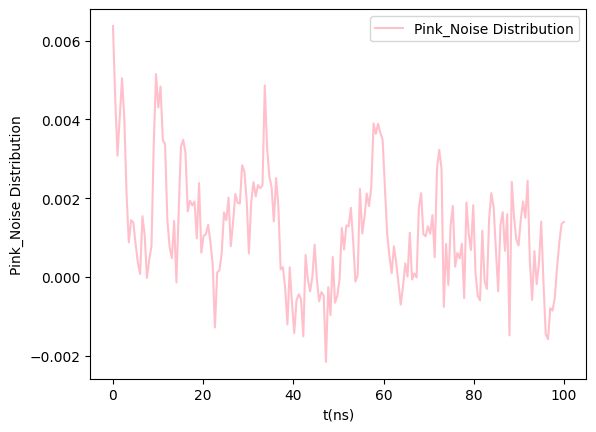

In [203]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise_1(tlist, args)

print(np.sqrt(np.mean(Pink_Noise_Sample**2)))

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

[-2.15089992 -0.51679324]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'FT Absolute Value (log scale)')

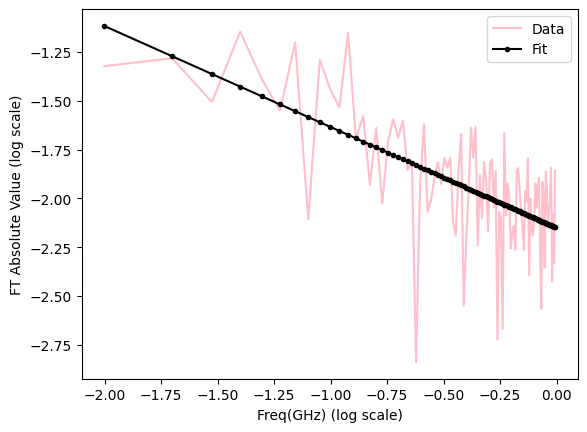

In [204]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])
print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

# CPMG

In [205]:
omega_q1 = 2 * np.pi * 5.1    # qubit frequency in units of GHz
omega_q2 = 2 * np.pi * 5.1    # qubit frequency in units of GHz
g12 = 2 * np.pi * 0.0901      # qubit coupling in units of GHz

gamma1_1 = (1/36)
gamma1_2 = (1/14)

gammaphi_1 = (1/31)- 0.5*gamma1_1
gammaphi_2 = (1/1.29) - 0.5*gamma1_2

In [206]:
gammaphi_1

0.018369175627240143

In [207]:
gammaphi_2

0.7394795127353266

In [214]:
state0L = (tensor(basis(2,0), basis(2,1)) - tensor(basis(2,1), basis(2,0)))/np.sqrt(2)
state1L = (tensor(basis(2,0), basis(2,1)) + tensor(basis(2,1), basis(2,0)))/np.sqrt(2)

state00 = tensor(basis(2,0), basis(2,0))
state01 = tensor(basis(2,0), basis(2,1))
state10 = tensor(basis(2,1), basis(2,0))
state11 = tensor(basis(2,1), basis(2,1))

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

proj00 = state00*state00.dag()
proj01 = state01*state01.dag()
proj10 = state10*state10.dag()
proj11 = state11*state11.dag()
proj0L = state0L*state0L.dag()
proj1L = state1L*state1L.dag()

sx_1 = tensor(sx, qeye(2))
sy_1 = tensor(sy, qeye(2))
sz_1 = tensor(sz, qeye(2))

sx_2 = tensor(qeye(2), sx)
sy_2 = tensor(qeye(2), sy)
sz_2 = tensor(qeye(2), sz)

sx_dressed = state0L*state1L.dag() + state1L*state0L.dag()
sy_dressed = (-1j)*state0L*state1L.dag() + (+1j)*state1L*state0L.dag()
sz_dressed = state0L*state0L.dag() - state1L*state1L.dag()


op_list = [sx_dressed, sy_dressed, sz_dressed, proj00, proj01, proj10, proj11, proj0L, proj1L]

H0 = -0.5*omega_q1*tensor(sz, qeye(2)) -0.5*omega_q2*tensor(qeye(2), sz) + g12*(tensor(sp, sm) + tensor(sm, sp))
H1 = sx_dressed

In [215]:
H0.eigenstates()

(array([-32.04424507,  -0.566115  ,   0.566115  ,  32.04424507]),
 array([Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[1.]
         [0.]
         [0.]
         [0.]]                                                                      ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.        ]
         [-0.70710678]
         [ 0.70710678]
         [ 0.        ]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.        ]
         [0.70710678]
         [0.70710678]
         [0.        ]]                                                              ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [0.]
         [0.]
         [1.]]                       

## Ramsey

In [233]:
# Simulation T1 & T2 process

N_seq = 0

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

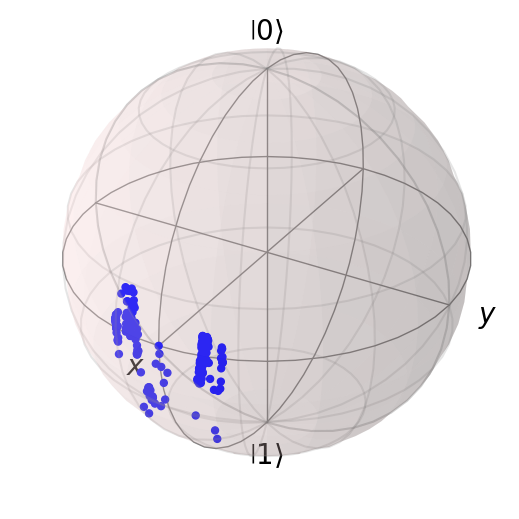

In [234]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

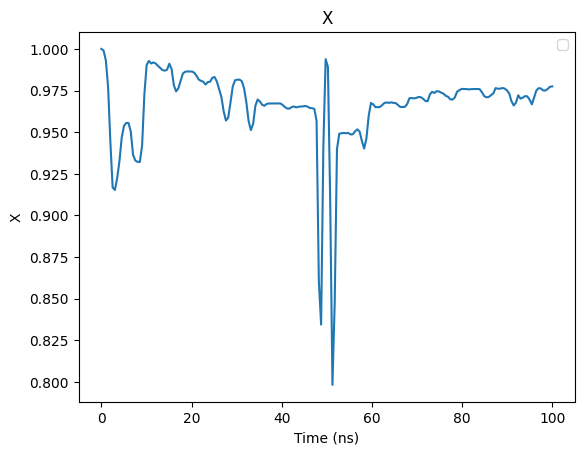

In [235]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

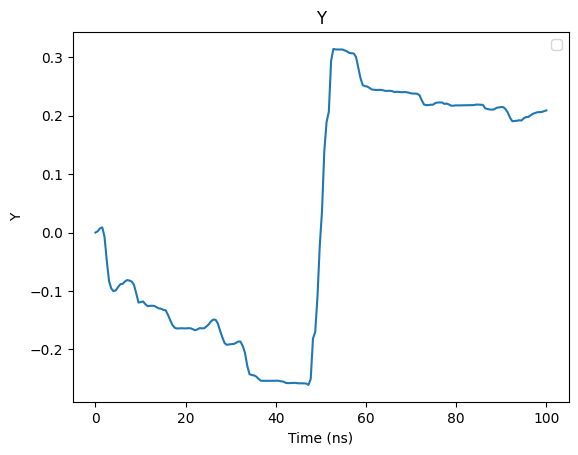

In [236]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

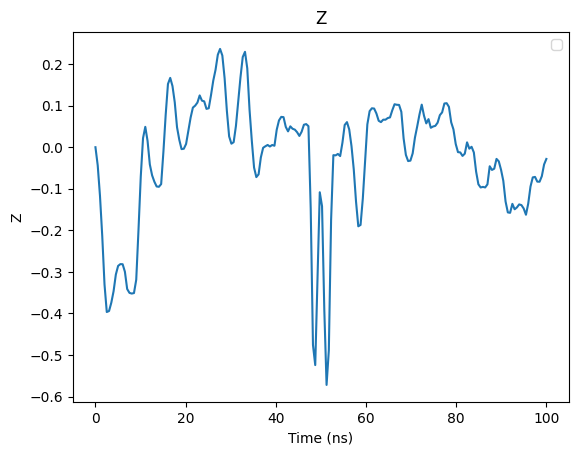

In [237]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

## Spin Echo

In [ ]:
# Simulation T1 & T2 process

N_seq = 1

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

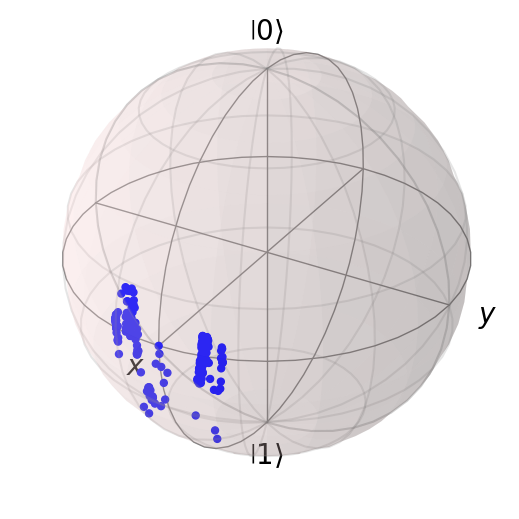

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

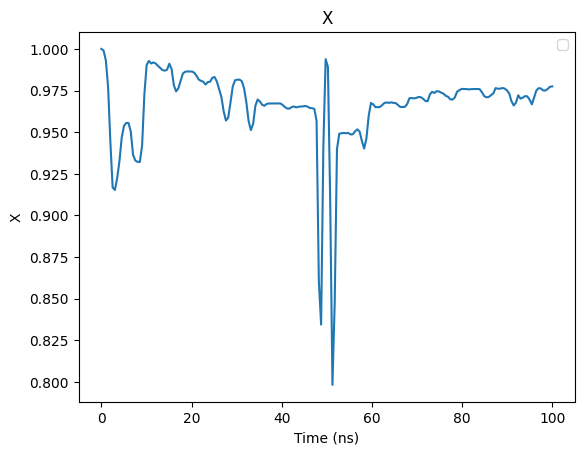

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

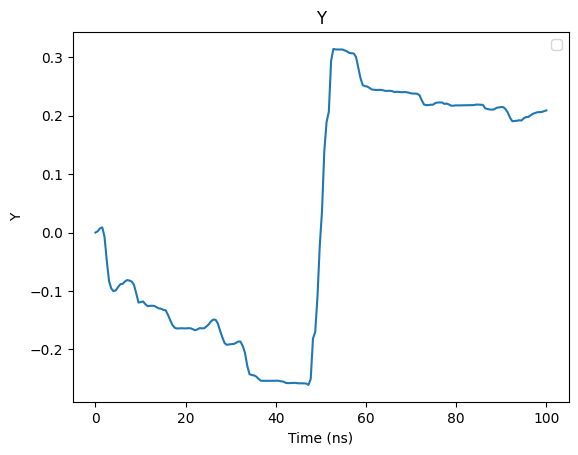

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

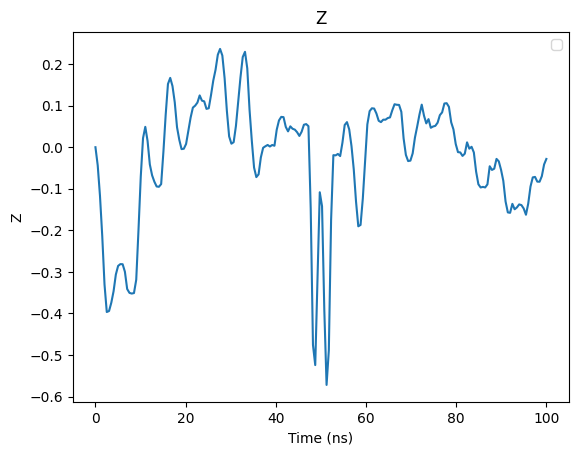

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

## CP (N=2)

In [ ]:
# Simulation T1 & T2 process

N_seq = 2

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

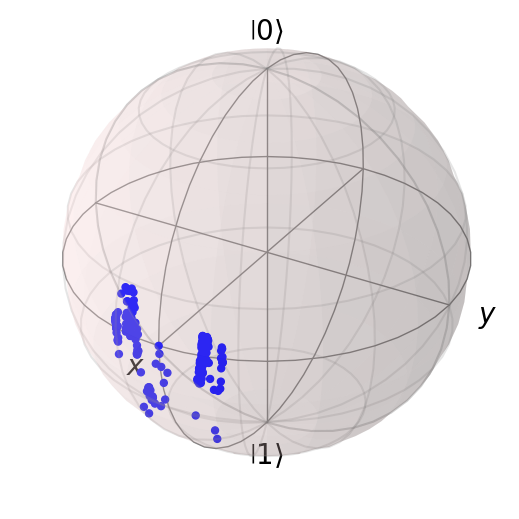

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

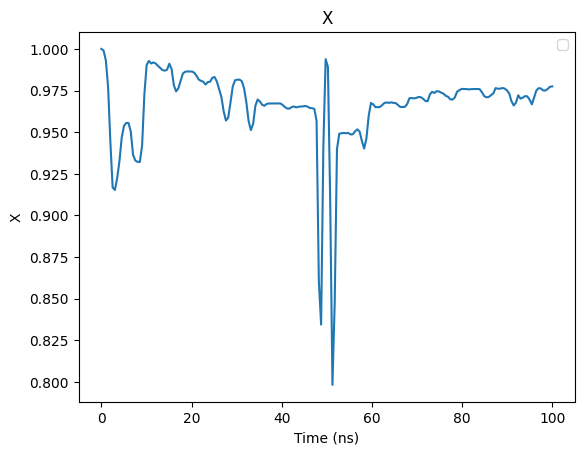

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

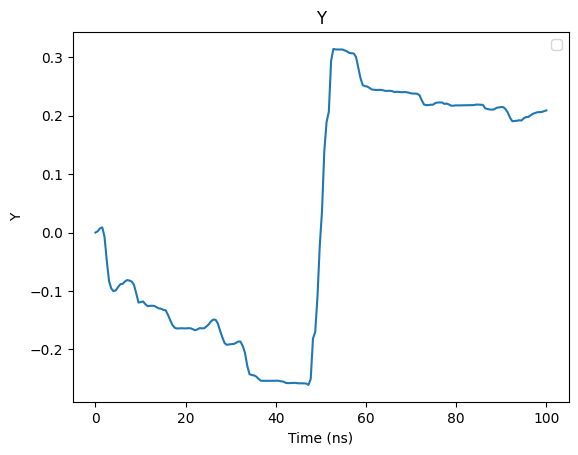

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

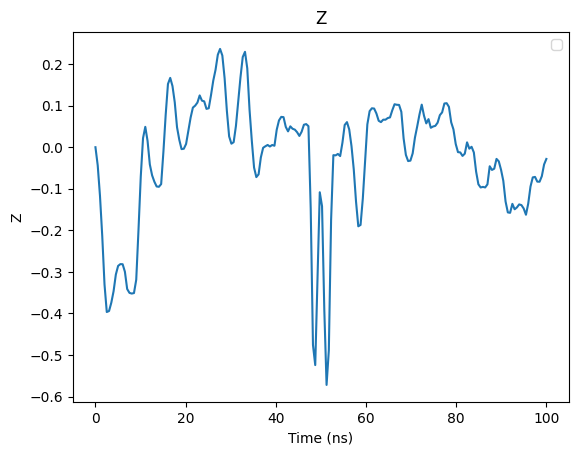

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

## CP (N=4)

In [ ]:
# Simulation T1 & T2 process

N_seq = 4

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

## CP (N=6)

In [ ]:
# Simulation T1 & T2 process

N_seq = 6

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

## CP (N=8)

In [ ]:
# Simulation T1 & T2 process

N_seq = 8

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist

## CP (N=10)

In [ ]:
# Simulation T1 & T2 process

N_seq = 10

xlist = []
ylist = []
zlist = []

for k in range(50):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  mu = 0
  sigma = 1

  A1 = 0.01837 * 0.0005
  A2 = 0.73948 * 0.0005

  B = 2*np.pi*0.1
  T_end_q = 100
  omega_qd = 2*g12

  tlist = np.linspace(0, 100, 200)

  result = mesolve(
      [H0, [-0.5*sz_1, Pink_Noise_1], [-0.5*sz_2, Pink_Noise_2], [H1, CP_lab_frame]],
      (state0L+state1L)/np.sqrt(2),
      tlist,
      c_ops = [],
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
      e_ops = op_list,
  )

  x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
  y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

  print(k+1)
  print(result.expect[0][-1])
  print(result.expect[1][-1])
  print(result.expect[2][-1])
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()
  print()
  print()

  xlist.append(result.expect[0][-1])
  ylist.append(result.expect[1][-1])
  zlist.append(result.expect[2][-1])

0.9959893763751075
0.08490008054155598
-0.028233640784732995
0.9996013513036276


In [ ]:
xlist

In [ ]:
ylist

In [ ]:
zlist